In [1]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

100%|██████████| 331M/331M [00:01<00:00, 178MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


In [2]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [1]:
# for file in os.listdir(os.path.join(path, 'UTKFace')):
#     print(f"File: {file}")

# Extracting Age and Gender (Age Detection will be added later)

In [4]:
# 0_0_0 pattern
pattern = r'(\d+)_(\d+)_(\d+)'
def extract_labels(filename):
    match = re.match(pattern, filename)
    if match:
        age = int(match.group(1))
        gender = int(match.group(2))
        return age, gender
    return None

# Map in usage (Diff from labels in the csv => Why? because ImageDataGenerator assign labels based on Alphabetical Order)

In [55]:
genderMap = {1: "Male", 0: "Female"}
Males = 0
Females = 0

In [ ]:
for file in os.listdir(os.path.join(path, 'UTKFace')):
    print(f"File: {file}")
    age, gender = extract_labels(file)
    print(f"Extracted Age: {age}")
    gender = genderMap[int(gender)]
    print(f"Extracted Gender: {gender}")
    if gender == "Male":
        Males+=1
    else:
        Females+=1


# **Check How Balanced The Dataset is**

In [7]:
print(f"Total Males: {Males}")
print(f"Total Females: {Females}")
print(f"Total Images: {Males + Females}")

Total Males: 12391
Total Females: 11317
Total Images: 23708


In [8]:
train = os.path.join(path, 'UTKFace', 'train')
print(f"Training Path: {train}")

val = os.path.join(path, 'UTKFace', 'val')
print(f"Validation Path: {val}")

test = os.path.join(path, 'UTKFace', 'test')
print(f"Testing Path: {test}")

Training Path: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/train
Validation Path: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/val
Testing Path: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/test


In [9]:
import os

train = '/content/train'
val = '/content/val'
test = '/content/test'

for folder in [train, val, test]:
    if not os.path.exists(folder):
        os.makedirs(folder)


In [10]:
import random
import shutil
ImgsPath = os.path.join(path, 'UTKFace')
np.random.seed(42)

images = [f for f in os.listdir(ImgsPath) if os.path.isfile(os.path.join(ImgsPath, f))]
random.shuffle(images)
imgLen = len(images)

trainLen = int(imgLen * 0.7)
valLen = int(imgLen * 0.2)
testLen = imgLen - trainLen - valLen

trainImages = images[:trainLen]
valImages = images[trainLen:trainLen + valLen]
testImages = images[trainLen + valLen:]


In [ ]:
for img in trainImages:
    shutil.copy2(os.path.join(ImgsPath, img), os.path.join(train, img))
    print(img," Moved to", train)
for img in valImages:
    shutil.copy2(os.path.join(ImgsPath, img), os.path.join(val, img))
    print(img," Moved to", val)
for img in testImages:
    shutil.copy2(os.path.join(ImgsPath, img), os.path.join(test, img))
    print(img," Moved to", test)

In [12]:
for folder in [train, test, val]:
    if not os.path.exists(os.path.join(folder, 'Male')):
        os.makedirs(os.path.join(folder, 'Male'))
    if not os.path.exists(os.path.join(folder, 'Female')):
        os.makedirs(os.path.join(folder, 'Female'))

# **Splitting each Split into two Classes Male and Female**

In [ ]:
import csv

for folder in [train, test, val]:
    with open(os.path.join(folder, 'labels.csv'), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['imgId', 'age', 'gender'])
        for img in os.listdir(folder):
            if not img.endswith('.jpg'):
                continue
            age, gender = extract_labels(img)
            if gender == 0:
                shutil.move(os.path.join(folder, img), os.path.join(folder, 'Male', img))
            else:
                shutil.move(os.path.join(folder, img), os.path.join(folder, 'Female', img))
            writer.writerow([img, age, gender])
            print(f"Image: {img}, Age: {age}, Gender: {gender}")

In [14]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TrainDataGen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
    )
ValDataGen = ImageDataGenerator(
rescale=1./255,
)
TestDataGen = ImageDataGenerator(
rescale=1./255,
)


In [15]:
TrainSet = TrainDataGen.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    color_mode ='rgb'
)
ValSet = ValDataGen.flow_from_directory(
    val,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    color_mode ='rgb'
)
TestSet = TestDataGen.flow_from_directory(
    test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    color_mode ='rgb'
)

Found 16595 images belonging to 2 classes.
Found 4741 images belonging to 2 classes.
Found 2372 images belonging to 2 classes.


# Model Training Phase

In [24]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Callbacks and Optims

In [25]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
modelCheckpoint = ModelCheckpoint('bestModel.keras', monitor='val_loss', save_best_only=True)
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001)
adam = Adam(learning_rate = lr_schedule)
sgd = SGD(learning_rate = 0.001)

In [26]:
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

### Training

In [29]:
hist = model.fit(x=TrainSet,
                validation_data=ValSet,
                epochs=10,
                callbacks=[earlyStopping, modelCheckpoint],
                verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 319s 576ms/step - accuracy: 0.6343 - loss: 12.5655 - val_accuracy: 0.7129 - val_loss: 0.5799
Epoch 2/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 212s 408ms/step - accuracy: 0.7668 - loss: 0.5298 - val_accuracy: 0.7340 - val_loss: 0.8080
Epoch 3/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 277s 534ms/step - accuracy: 0.7867 - loss: 0.5395 - val_accuracy: 0.8043 - val_loss: 0.4729
Epoch 4/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 303s 498ms/step - accuracy: 0.8073 - loss: 0.4142 - val_accuracy: 0.8389 - val_loss: 0.3697
Epoch 5/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 272s 524ms/step - accuracy: 0.8235 - loss: 0.4054 - val_accuracy: 0.8378 - val_loss: 0.3494
Epoch 6/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 211s 406ms/step - accuracy: 0.8254 - loss: 0.4150 - val_accuracy: 0.8498 - val_loss: 0.3553
Epoch 7/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 211s 406ms/step - accuracy: 0.8344 - loss: 0.3705 - val_accuracy: 0.7977 - val_loss: 0.9731
Epoch 8/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 211s 406ms/step - accuracy: 0.8129 

### Testing

In [31]:
eval = model.evaluate(TestSet)

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8627 - loss: 0.3023


In [36]:
print("Val Acurracy is => ",round(eval[1], 3))
print("Val Loss is => ",round(eval[0], 3))

Val Acurracy is =>  0.864
Val Loss is =>  0.293


In [49]:
for i, photo in enumerate(TestSet):
  if i > 10:
    break
  print(photo)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipython-input-66-1026601087.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title("Actual: " + genderMap[int(actualLabels[i])] + ", Predicted: " + genderMap[int(predictedLabels[i])])


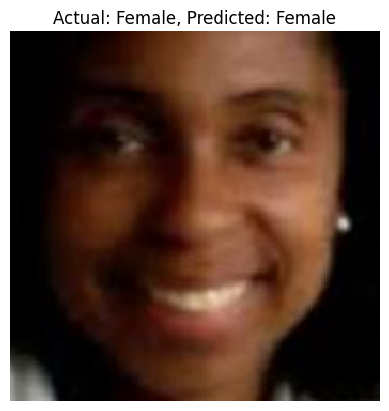

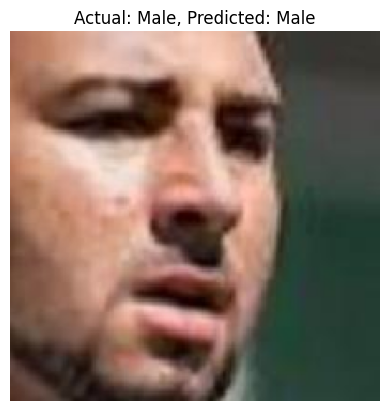

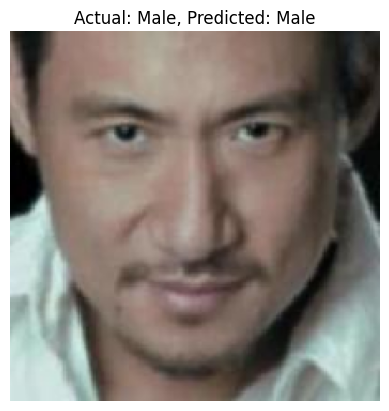

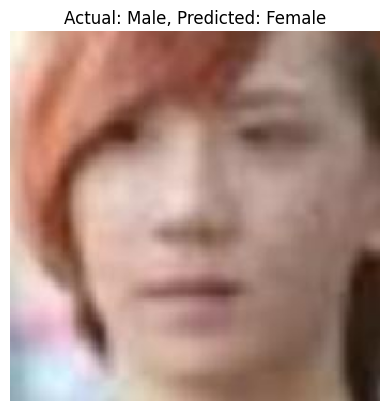

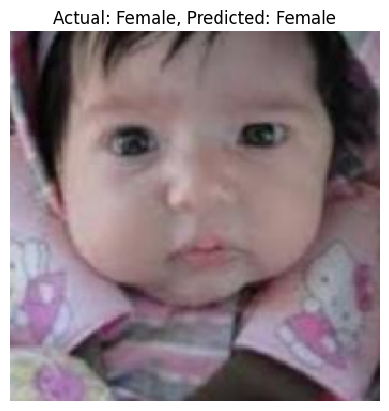

In [66]:
import numpy as np
import matplotlib.pyplot as plt

images, labels = next(TestSet)
np.random.seed(42)
random_indices = np.random.choice(len(images), size=5, replace=False)
testImages = images[random_indices]
actualLabels = labels[random_indices]

predictions = model.predict(testImages)
predictedLabels = np.round(predictions)

# print("Actual Labels: ", actualLabels)
# print("Predicted Labels: ", predictedLabels)
for i, img in enumerate(testImages):
  plt.imshow(img)
  plt.title("Actual: " + genderMap[int(actualLabels[i])] + ", Predicted: " + genderMap[int(predictedLabels[i])])
  plt.axis('off')
  plt.show()

-------------
# Thank YOU!!
-------------

